In [43]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
from sklearn import metrics
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [44]:
# preprocess the dataset 
def preprocess_images(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through each subfolder (character class)
    for char_folder in os.listdir(input_folder):
        char_folder_path = os.path.join(input_folder, char_folder)

        if os.path.isdir(char_folder_path):
            output_char_folder = os.path.join(output_folder, char_folder)

            # Create the output subfolder for the character class
            if not os.path.exists(output_char_folder):
                os.makedirs(output_char_folder)

            # Iterate through each image in the character class subfolder
            for filename in os.listdir(char_folder_path):
                if filename.lower().endswith((".jpg", ".jpeg", ".png")):
                    # Read the image using Pillow
                    image_path = os.path.join(char_folder_path, filename)

                    img = Image.open(image_path).convert('L')  # Open and convert to grayscale
                    img = img.resize((28, 28))  # Resize to 28x28 pixels

                    # Extract HOG features
                    features, hog_image = hog(np.array(img), visualize=True)
                    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

                    # Save the HOG image (for visualization purposes, optional)
                    hog_image_path = os.path.join(output_char_folder, "hog_" + filename)
                    Image.fromarray((hog_image_rescaled * 255).astype(np.uint8)).save(hog_image_path)

                    # Save the HOG features as a NumPy array
                    features_path = os.path.join(output_char_folder, "features_" + filename.replace(".", "_") + ".npy")
                    np.save(features_path, features)

if __name__ == "__main__":
    # path to the dataset
    input_folder = r"C:\Users\Bizuhan\Downloads\dogs-vs-cats"
    output_folder = r"C:\Users\Bizuhan\Downloads\dogs-vs-cats features"

    preprocess_images(input_folder, output_folder)

In [45]:
# Function to load data
def load_data(folder):
    features_list = []
    labels_list = []

    for char_folder in os.listdir(folder):
        char_folder_path = os.path.join(folder, char_folder)

        if os.path.isdir(char_folder_path):
            for filename in os.listdir(char_folder_path):
                if filename.startswith("features_") and filename.endswith(".npy"):
                    features_path = os.path.join(char_folder_path, filename)
                    label = char_folder  # Use folder name as label

                    features = np.load(features_path)
                    features_list.append(features)
                    labels_list.append(label)

    return np.array(features_list), np.array(labels_list)

# Load data
input_folder = r"C:\Users\Bizuhan\Downloads\dogs-vs-cats features"
features, labels = load_data(input_folder)

# Encoding labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [48]:
# Define DNN models with different activation functions
def build_model(activation):
    model = models.Sequential([
        layers.Flatten(input_shape=(X_train.shape[1],)),
        layers.Dense(256, activation=activation),
        layers.Dense(128, activation=activation),
        layers.Dense(len(np.unique(labels)), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define DNN models with the ReLU variants
def build_relu_model(relu_variant):
    model = models.Sequential([
        layers.Flatten(),
        layers.Dense(256),
        layers.Dense(128)
    ])
    if relu_variant == 'leaky_relu':
        model.add(layers.LeakyReLU(negative_slope=0.1))
    elif relu_variant == 'parametric_relu':
        model.add(layers.PReLU())
    else:
        model.add(layers.ReLU())
    model.add(layers.Dense(len(np.unique(labels)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [55]:
# Train models with different activation functions
activations = ['sigmoid', 'tanh', 'relu']
activation_models_history = {}

for activation in activations:
    model = build_model(activation)
    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=0)
    activation_models_history[activation] = history

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    # print(f"Test Accuracy ({activation}): {test_accuracy * 100:.2f}%")
    
# Train models with different ReLU variants
relu_variants = ['relu', 'leaky_relu', 'parametric_relu']
relu_models_history = {}

for relu_variant in relu_variants:
    model = build_relu_model(relu_variant)
    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=0)
    relu_models_history[relu_variant] = history

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    # print(f"Test Accuracy ({activation}): {test_accuracy * 100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6792 - loss: 0.6064
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6444 - loss: 0.6888
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6258 - loss: 5.4044
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6319 - loss: 2.3442
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6444 - loss: 1.9532
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6149 - loss: 2.4660


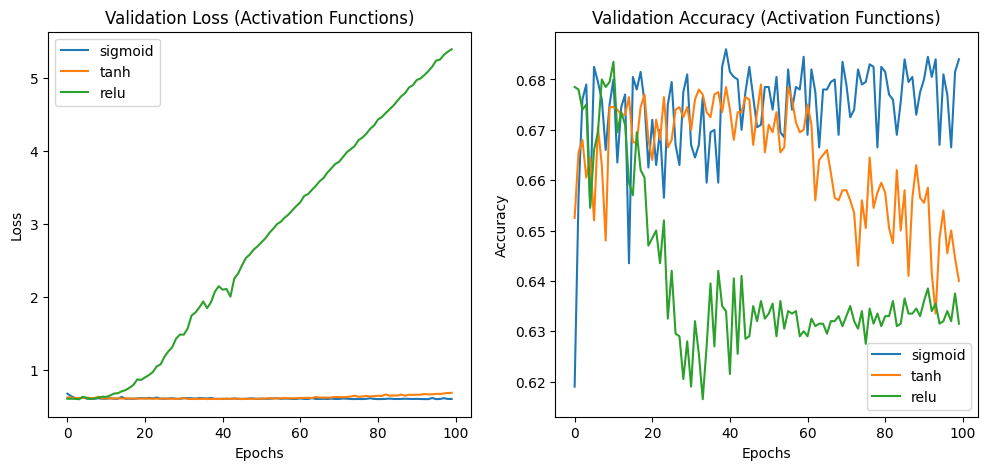

In [56]:
# Plot performance for different activation functions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for activation, history in activation_models_history.items():
    plt.plot(history.history['val_loss'], label=activation)
plt.title('Validation Loss (Activation Functions)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for activation, history in activation_models_history.items():
    plt.plot(history.history['val_accuracy'], label=activation)
plt.title('Validation Accuracy (Activation Functions)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

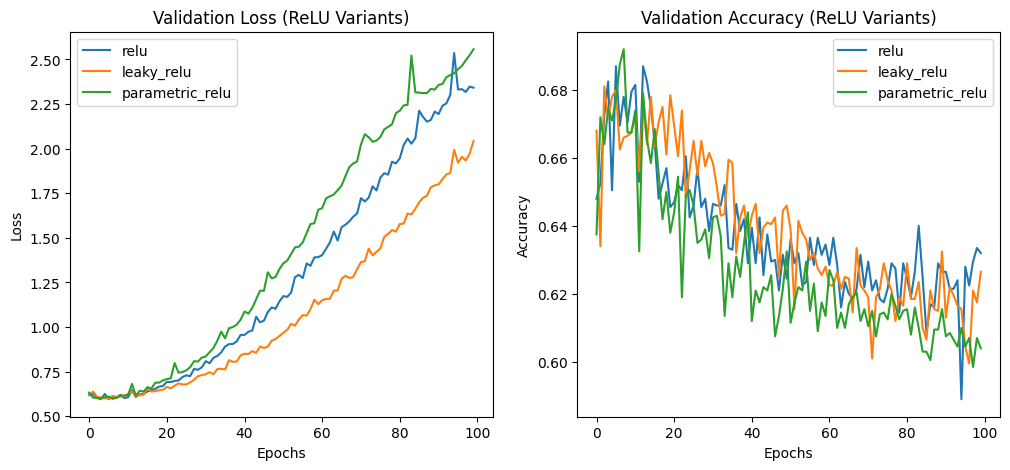

In [57]:
# Plot performance for different ReLU variants
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for relu_variant, history in relu_models_history.items():
    plt.plot(history.history['val_loss'], label=relu_variant)
plt.title('Validation Loss (ReLU Variants)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for relu_variant, history in relu_models_history.items():
    plt.plot(history.history['val_accuracy'], label=relu_variant)
plt.title('Validation Accuracy (ReLU Variants)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [58]:
# Define DNN models with different depths
def build_deep_model(depth):
    model = models.Sequential([
        layers.Flatten(input_shape=(X_train.shape[1],))
    ])
    for _ in range(depth):
        model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(len(np.unique(labels)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train models with depths upto 5
depths = [1, 2, 3, 4, 5]
depths_models_history = {}

for depth in depths:
    model = build_deep_model(depth)
    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=0)
    depths_models_history[depth] = history

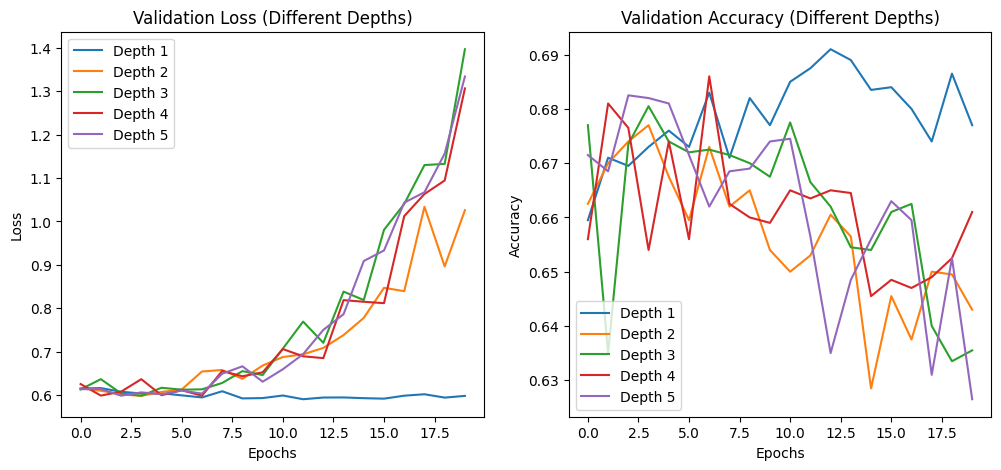

In [54]:
# Plot performance for different depths
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for depth, history in depths_models_history.items():
    plt.plot(history.history['val_loss'], label=f'Depth {depth}')
plt.title('Validation Loss (Different Depths)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for depth, history in depths_models_history.items():
    plt.plot(history.history['val_accuracy'], label=f'Depth {depth}')
plt.title('Validation Accuracy (Different Depths)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
